<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Intel_Image_Classification10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Need v1.0.25 of fastai which is not yet published so install it from GitHub.

In [0]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow==1.2

# For the latest nightly build:
#!pip install tf-nightly


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

In [0]:
import torch
print(torch.__version__)
!pip install torchtext==0.2.3
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
!pip install fastai

In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd 

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

#  Intel Scene Classification Image Dataset

## Looking at the data

###Getting Dataset from Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"navneetkrch","key":"4910f3543e9486158ccfa00ca84b274f"}'> ~/.kaggle/kaggle.json  # Replace
!chmod 600 kaggle.json


chmod: cannot access 'kaggle.json': No such file or directory


In [0]:
!mkdir -p data
!kaggle datasets download -d nitishabharathi/scene-classification

 98% 351M/358M [00:06<00:00, 78.2MB/s]
100% 358M/358M [00:06<00:00, 57.3MB/s]


In [0]:
!unzip scene-classification.zip 

Archive:  scene-classification.zip
  inflating: test_WyRytb0.csv        
  inflating: train-scene classification.zip  


In [0]:
!unzip train-scene\ classification.zip -d data/
!mv test_WyRytb0.csv data/test.csv
!mv data/train.csv data/train/labels.csv

In [0]:
print("all files unzipped. Images in train folder and labels in test.csv")

all files unzipped. Images in train folder and labels in test.csv


###Setting the path for data

We are going to use the [Intel Image Scene](https://www.kaggle.com/nitishabharathi/scene-classification) by [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-intel-scene-classification-challe/) which features 6 scenes.

Our model will need to learn to differentiate between these 6 distinct categories. 
We use **FASTAI-V1** model to get the results.

####DATASET DESCRIPTION
**There are 17034 images in train and 7301 images in test data.**

The categories of natural scenes and their corresponding labels in the dataset are as follows -

 ** 'buildings' -> 0,**

**'forest' -> 1,** 

**'glacier' -> 2,**

**'mountain' -> 3,**

**'sea' -> 4, **

**'street' -> 5 **

There are three files provided to you, viz **train.zip, test.csv and sample_submission.csv** which have the following structure.

Variable	Definition

image_name	Name of the image in the dataset (ID column)

label	Category of natural scene (target column)

**train.zip contains the images corresponding to both train and test set along with the true labels for train set images in train.csv**

In [0]:
path = 'data';path

'data'

In [0]:
path_img = 'data/train'

In [0]:
fnames = get_image_files(path_img)
fnames[:5]


[PosixPath('data/train/23062.jpg'),
 PosixPath('data/train/2299.jpg'),
 PosixPath('data/train/8889.jpg'),
 PosixPath('data/train/23254.jpg'),
 PosixPath('data/train/15502.jpg')]

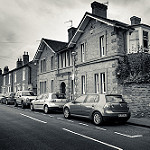

In [0]:
from IPython.display import Image 
Image(filename='data/train/13664.jpg')

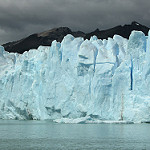

In [0]:
from IPython.display import Image 
Image(filename='data/train/11432.jpg')

In [0]:
os.listdir('data/')

['test.csv', 'labels.csv', 'train']

###Loading and Understanding the Data
The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data, means **understanding how the data directories are structured**, what the **labels** are and what some **sample images** look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, **6 labels** are stored based on the csv files.

Fortunately, the fastai library has a handy function made exactly for this.

[Image data from CSV / DataFrame](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_csv).

##Loading Labels [From_CSV](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L131)

from_csv[source]

from_csv(`path`:PathOrStr, `folder`:PathOrStr=`'.'`, `sep`=`None`, `csv_labels`:PathOrStr=`'labels.csv'`, `valid_pct`:float=`0.2`, `fn_col`:int=`0`, `label_col`:int=`1`, `suffix`:str=`''`, `header`:Union[int, str, NoneType]=`'infer'`, `kwargs`:Any) → ImageDataBunch

Create from a csv file in path/csv_labels.

**data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=24);**




**File Structure**

path\

    labels.csv -> label for training images
    test.csv -> list of test images without labels
    
    train\
      all images
      
 train.csv contains correct labels of **17034 images** in train 
 
 test.csv contains list of **7301 images** in train folder itself but without labels.


In [0]:
tfms = get_transforms()
data = ImageDataBunch.from_csv(path, train='train','../labels.csv', valid_pct=0.2, ds_tfms=tfms, size=224,classes=[str(i) for i in range(6)])

SyntaxError: ignored

In [0]:
data = ImageDataBunch.from_csv(path_img, ds_tfms=tfms, size=224)

In [0]:
label_df = pd.read_csv('data/train/labels.csv')
label_df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [0]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4, 5]


(6, 6)

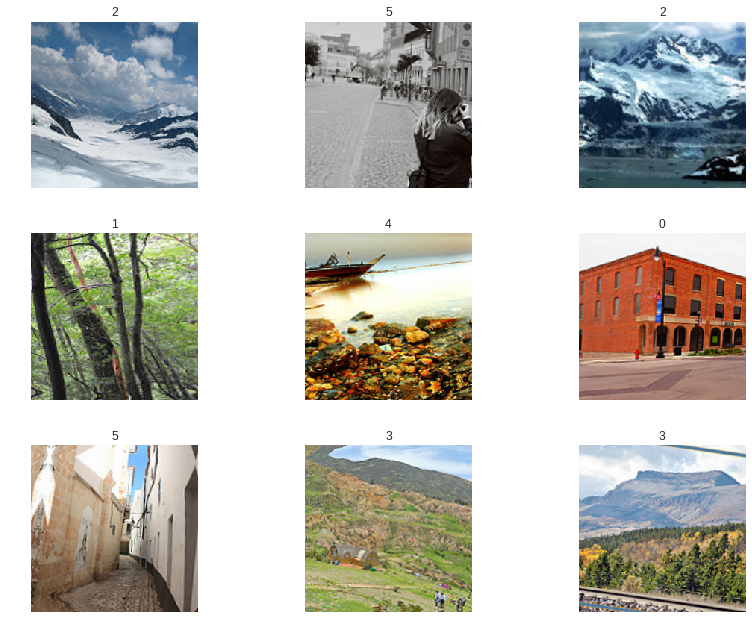

In [0]:
data.show_batch(rows=3, figsize=(12,9))

# Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
#For Metrics to have Top 3 results
from fastai import *
from sklearn import metrics as skm

In [0]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


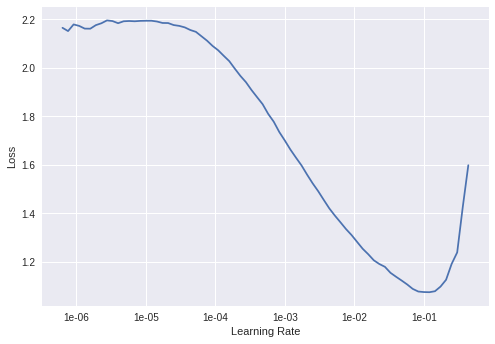

In [0]:
learn.lr_find()
learn.recorder.plot()

##Train and save the model checkpoint

In [0]:
learn.fit_one_cycle(10) ## best way to fit as of 2018
print("learning complete")

epoch,train_loss,valid_loss,accuracy
1,0.174162,0.193229,0.928655
2,0.197513,0.204719,0.926600
3,0.195552,0.193455,0.932178
4,0.174018,0.190158,0.935115
5,0.154316,0.201387,0.931004
6,0.147637,0.198803,0.933647
7,0.133024,0.181788,0.937463
8,0.112367,0.183474,0.938344
9,0.100917,0.177812,0.940987
10,0.102031,0.180846,0.940693


learning complete


In [0]:
print("we save after 1st weights are learned")
learn.save('stage-1-50')
learn.load('stage-1-50')

Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()

#learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-2))
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.123565,0.196381,0.932766
2,0.160047,0.212591,0.932766
3,0.170815,0.202875,0.934527
4,0.135491,0.254014,0.923371
5,0.111719,0.225406,0.934527
6,0.086330,0.217526,0.934234
7,0.048115,0.207164,0.943922
8,0.038952,0.221928,0.940399
9,0.019031,0.224708,0.942455
10,0.014516,0.221415,0.943629


In [0]:
learn.save('stage-3-50')
#learn.load('stage-2-50')

print("we save after 2nd weights are learned")

we save after 2nd weights are learned


If it doesn't, you can always go back to your previous model.

In [0]:
print("weights loaded")

weights loaded


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

**interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability**

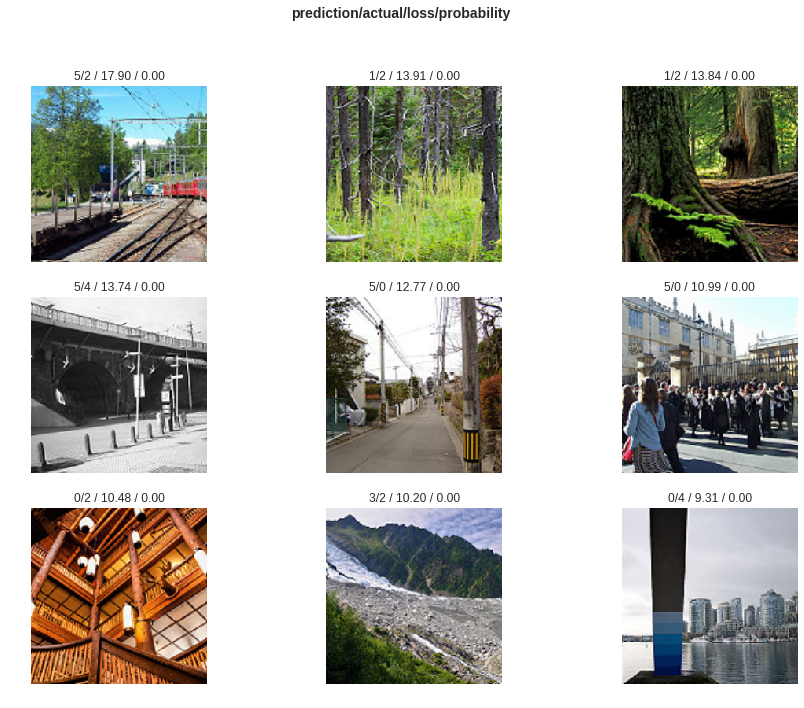

In [0]:
interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability

In [0]:
interp.most_confused()

[(2, 3, 63),
 (0, 5, 38),
 (3, 2, 30),
 (5, 0, 12),
 (2, 4, 11),
 (2, 1, 9),
 (4, 2, 7),
 (3, 4, 5),
 (4, 3, 4),
 (1, 3, 2),
 (3, 1, 2),
 (4, 5, 2)]

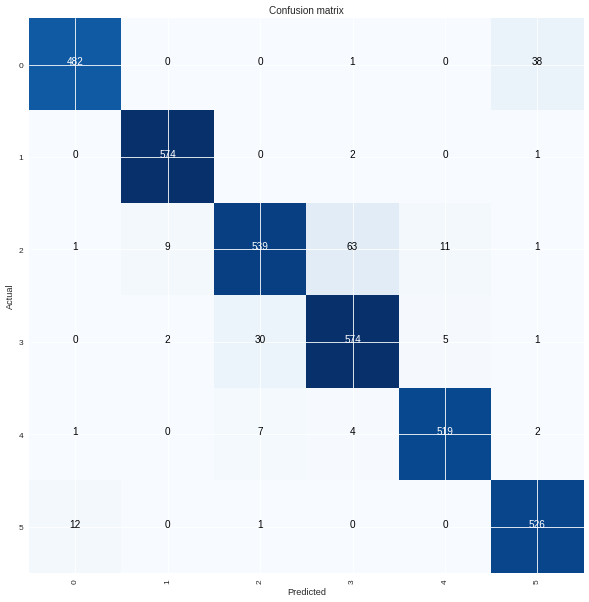

In [0]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)



---



##Start the Prediction for the Test Dataset based on test csv

Add test files seeing the documentation available at 
complte documentation as well
https://docs.fast.ai/data_block.html



In [0]:
#test_files = os.listdir('data/test')
#test_df = pd.read_csv(f'{path}test.csv')
#print("test files are") 
#test_files
#test_file_name = pd.DataFrame(test_files)
print(test_file_name.nunique())


0    118972
dtype: int64


In [0]:
#demo = []
  img = learn.data.test_ds[0][0]
  a = learn.predict(img)
  b = list(a)[2]
  print(a)
  c = pd.DataFrame([[i, b[i]] for i in range(len(b))])
  c.columns = ["class","probability"]
  #print(c)
  d = c.sort_values("probability", ascending = False)
  #demo.append(d[:3])
  #d = sorted(c, reverse = True)
  print(d[:3])

#??learn.predict

('5', tensor(5), tensor([1.0619e-03, 5.7075e-04, 3.1694e-05, 9.8312e-02, 7.5517e-04, 6.0975e-01,
        2.6074e-04, 1.9710e-02, 1.1016e-03, 4.9596e-05, 3.6740e-04, 4.6607e-04,
        9.4483e-04, 2.2834e-03, 1.8599e-04, 1.0987e-03, 4.7389e-03, 5.8778e-03,
        3.7234e-03, 4.0222e-02, 1.1303e-03, 2.0926e-04, 1.2369e-02, 9.1633e-05,
        3.1829e-03, 3.3656e-03, 2.4895e-04, 8.0215e-02, 7.5060e-03, 7.5550e-03,
        6.4346e-04, 3.1171e-02, 4.8743e-04, 2.8643e-02, 2.3060e-03, 3.5001e-04,
        3.9306e-04, 1.6949e-02, 1.3296e-04, 2.1957e-04, 8.6279e-04, 1.5542e-03,
        8.8980e-03]))
    class     probability
5       5  tensor(0.6098)
3       3  tensor(0.0983)
27     27  tensor(0.0802)


In [0]:
preds,_ = learn.get_preds(DatasetType.Test);

In [0]:
pred,y = learn.TTA(DatasetType.Test);

In [0]:
# Predict into the test set
learn.get_preds(DatasetType.Test)
test_output = learn.get_preds(is_test=True)
log_probs, y = test_output

In [0]:
DatasetType.Test[0]

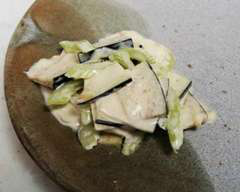

In [0]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

data.test_ds.x

test.
#pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)];pred_labels
#df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
#df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)

In [0]:
preds.info()


AttributeError: ignored

In [0]:
predsnp = np.array(preds)
predsdf = pd.DataFrame(predsnp)

In [0]:
predsdf

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.001062,0.000571,0.000032,0.098312,0.000755,0.609755,0.000261,0.019710,0.001102,0.000050,...,0.028643,0.002306,0.000350,0.000393,0.016949,0.000133,0.000220,0.000863,0.001554,0.008898
1,0.002367,0.004050,0.001025,0.118980,0.007047,0.123734,0.002359,0.146626,0.023174,0.000726,...,0.040158,0.002642,0.000750,0.002493,0.028960,0.001654,0.004573,0.002348,0.004514,0.116055
2,0.000905,0.000166,0.000005,0.075871,0.000029,0.610915,0.000052,0.060320,0.001085,0.000019,...,0.077190,0.001180,0.000072,0.000192,0.025148,0.000199,0.000055,0.000117,0.001040,0.008479
3,0.001686,0.000229,0.000043,0.022713,0.000076,0.055560,0.000120,0.005324,0.000224,0.000055,...,0.014284,0.000642,0.000007,0.000507,0.004404,0.000055,0.000456,0.000081,0.000734,0.826633
4,0.004961,0.006043,0.000871,0.059274,0.000740,0.224985,0.001920,0.106376,0.006968,0.000994,...,0.171948,0.006895,0.003902,0.002421,0.057550,0.002819,0.001739,0.001450,0.015610,0.012267
5,0.001497,0.000977,0.000248,0.016924,0.000402,0.587588,0.000618,0.011896,0.000709,0.000533,...,0.014257,0.002221,0.000499,0.007444,0.025402,0.000293,0.000210,0.000843,0.002009,0.007049
6,0.001720,0.001635,0.000087,0.014692,0.000233,0.221438,0.000494,0.443637,0.013988,0.000372,...,0.041124,0.002759,0.000450,0.000521,0.032753,0.001109,0.000137,0.001494,0.011103,0.010653
7,0.003024,0.008938,0.002607,0.072964,0.009912,0.066287,0.002012,0.021986,0.006784,0.001955,...,0.025206,0.004948,0.003801,0.004514,0.032459,0.001171,0.003962,0.001786,0.007521,0.019915
8,0.003023,0.004002,0.000339,0.031542,0.002439,0.290957,0.001205,0.036883,0.002114,0.003108,...,0.233333,0.005967,0.004047,0.040742,0.056661,0.004928,0.000878,0.002301,0.005364,0.007579
9,0.000771,0.000450,0.000006,0.027304,0.000107,0.203986,0.000099,0.545122,0.011042,0.000027,...,0.015797,0.000994,0.000036,0.000257,0.010126,0.000210,0.000060,0.000206,0.006214,0.004384


In [0]:
predsdf.to_csv("preds.csv")